# Geneate Configurations of 1D XY model and train RBM on that.

### Its not easy to generate the samples from XY model - we discretize the angles and use potts model instaed.

In [1]:
import sys
import os
sys.path.append('Jerome_scripts_Original/PGM/')
sys.path.append('selfPackages/')
sys.path.append('Jerome_scripts_Original/')
sys.path.append('ffmpeg-3.4.2-32bit-static/')

import numpy as np
import scipy as sc
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

try:
    import rbm
    import bm
except:
    print 'Compiling cy_utilities first'
    curr_dir = os.getcwd()
    os.chdir('PGM/')
    !python setup.py build_ext --inplace
    print 'Compilation done'
    os.chdir(curr_dir)
    
import pickle
from ising import IsingModel
import estimate_correlations_ising
from sklearn.utils import shuffle
import inlineMovies

In [ ]:
#import dill
#dill.dump_session('./data_bruckner/data/notebookData/25_XYmodel_2D')

In [ ]:
#import dill
#dill.load_session('./data_bruckner/data/notebookData/25_XYmodel_2D')

In [57]:
# Save the data array with the 1d XY model configurations: Expensive to generate over again.
#np.save('./data_bruckner/data/notebookData/data_XY1D_1million_beta1.0_size100_states=10',data)
#data = np.load('./data_bruckner/data/notebookData/data_XY1D_1million_beta1.0_size100_states=10.npy')

In [50]:
#%%capture capt1
#Supress the output of the cell and save it to capt1

size = 50
N = size**2
beta = 0.63
Num_configs = 2
Num_states=20

#Generate spins using Gibbs Sampling MCMC
BM = bm.BM(N=N,nature='Potts',n_c=10)

#Define Couplings
BM.layer.couplings = XY2dCouplings(BM,size=size,beta1=beta,beta2=beta,num_states=num_states,PBC=True)

data = BM.gen_data(Nchains=1,Nthermalize=0,Lchains=Num_configs,Nstep=200) # N steps.

#Estimate Correlations for number of MC steps
#plt.plot(data.mean(1)[0:10000]);plt.show()

#import estimate_correlations_ising
#Xcorr = estimate_correlations_ising.spin_autocorr(data,n_max=int(Num_configs*0.1))
#plt.plot(Xcorr);plt.show()

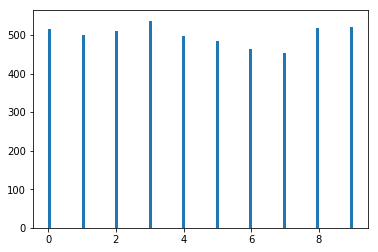

In [51]:
plt.hist(np.ndarray.flatten(data),100);plt.show()

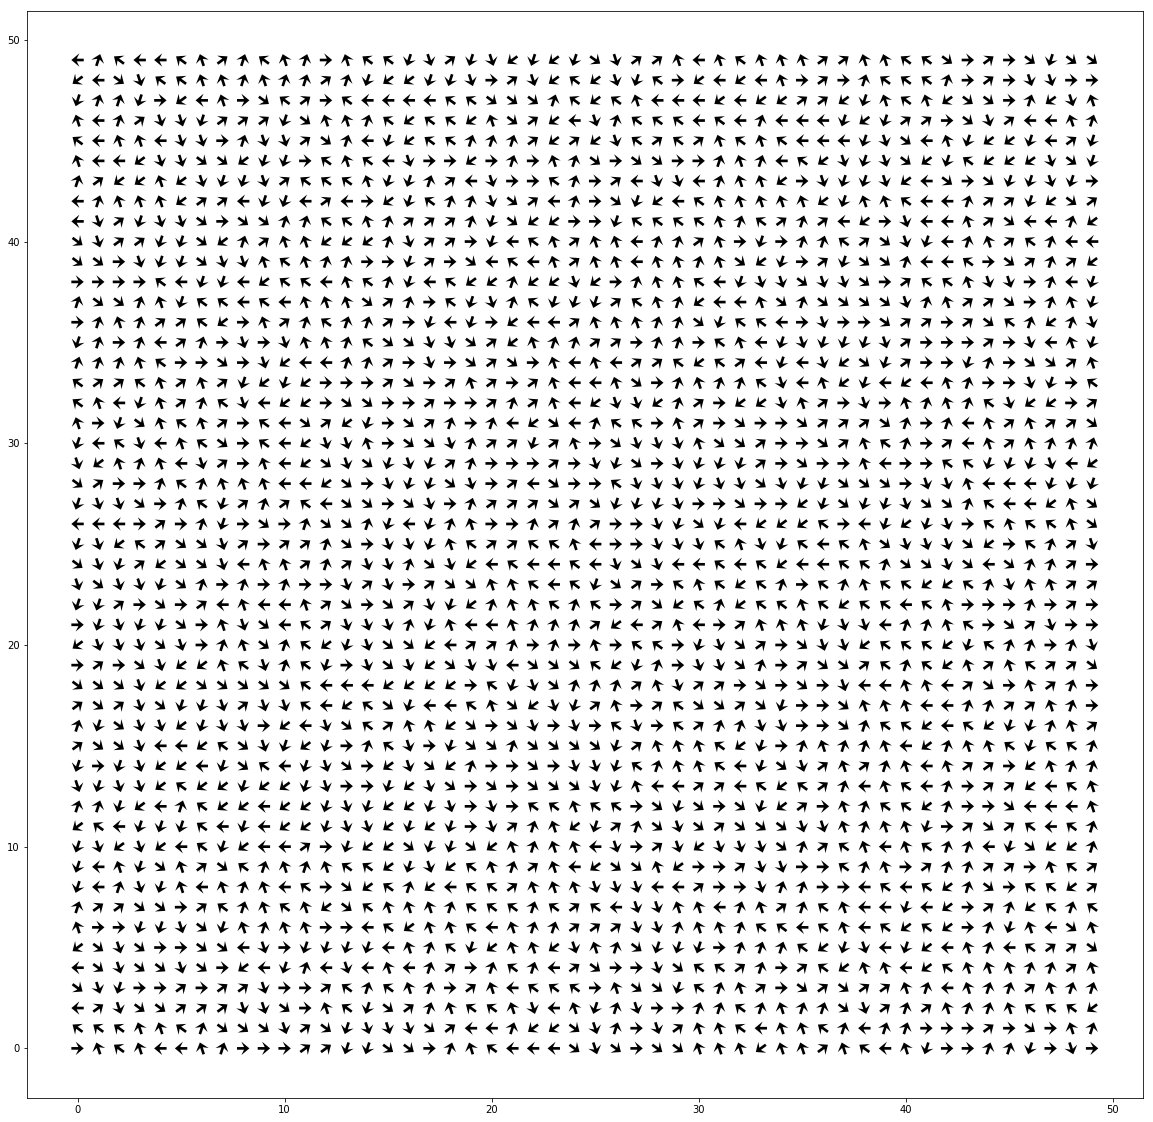

In [53]:
#Visualize the XY Spins as a vector field:
plt.figure(figsize=(20,20))
plt.quiver(np.cos(np.reshape(data[-1,:],(size,size))*2*np.pi/num_states),\
           np.sin(np.reshape(data[-1,:],(size,size))*2*np.pi/num_states), pivot='mid', units='width',headwidth=5,headaxislength=2,headlength=3)

In [3]:
def XY1dCouplings(BM,size=100,beta=1.0,num_states=10,PBC=False):
    
    # This is only the nearest neighbour interactions XY model on a 1D lattcie
    pottsCouplings = np.zeros([num_states,num_states])
    
    for i in np.arange(0,num_states):
        for j in np.arange(0,num_states):
            pottsCouplings[i,j] = np.cos((i-j)*2*np.pi/num_states)
        
    BM.layer.couplings[(np.eye(N=size,k=-1)+np.eye(N=size,k=+1)).astype(bool),:,:] = beta*pottsCouplings
    
    if PBC is True:
        BM.layer.couplings[0,-1] = beta*pottsCouplings
        BM.layer.couplings[-1,0] = beta*pottsCouplings
    
    return BM.layer.couplings

In [4]:
def XY2dCouplings(BM,size=20,beta1=1.0,beta2=1.0,num_states=10,PBC=False):
    
    # This is only the nearest neighbour XY model on a 2D square lattice
    # Calculate the KT transition beta
        
    pottsCouplings = np.zeros([num_states,num_states])
    N = size
    
    for i in np.arange(0,num_states):
        for j in np.arange(0,num_states):
            pottsCouplings[i,j] = np.cos((i-j)*2*np.pi/num_states)
            
    BM.layer.couplings[(np.eye(N=size**2,k=1) + np.eye(N=size**2,k=-1)).astype(bool),:,:] =  beta1*pottsCouplings
    BM.layer.couplings[(np.eye(N=size**2,k=size) + np.eye(N=size**2,k=-size)).astype(bool),:,:] =  beta2*pottsCouplings
    
    # Remove the couplings of the left most coloumn to that of the last coloumn in its previous row:
    for i in np.arange(0,N*N,N):
        BM.layer.couplings[i,i-1] = 0
        BM.layer.couplings[i-1,i] = 0
    
    if PBC is True:
        # Add the couplings of the first row to that of the last row and vice versa:
        for i in np.arange(0,N):
            BM.layer.couplings[i,(size**2)-N+i] = beta2*pottsCouplings
            BM.layer.couplings[(size**2)-N+i,i] = beta2*pottsCouplings
        # Add the couplings of the left most column to the right most coloumn:
            BM.layer.couplings[i,i+N-1] = beta1*pottsCouplings
            BM.layer.couplings[i+N-1,i] = beta1*pottsCouplings
    
    return BM.layer.couplings

In [ ]:
#Train the model
RBM = rbm.RBM(visible = 'Potts', n_cv=10, n_v=N, n_h = 1, n_ch=10, hidden = 'Potts',zero_field = True)
results = RBM.fit(data[0:-1],n_iter=100,verbose=0,learning_rate = 0.01,record=['W'],record_interval=100,batch_size=100,N_MC= 20, lr_decay=False,batch_norm=False);

Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6


In [72]:
# Top Eignvectors of the C_ij matrix:
def topEV(data,method='Covariance'):
    if method is 'Covariance':
        #Find the covariance matrix:
        covMAT = np.cov(data)
    elif method is 'Correlation':
        covMAT = np.corrcoef(data)
    Eval,Evec = np.linalg.eig(covMAT)
    return Evec[:,np.argmax(Eval)],np.max(Eval)

In [ ]:
# Store the top Eigenvalue of the Potts matrix at the last time point and for all Weights
topEval = np.zeros((np.shape(np.array(results['W']))[0],np.shape(np.array(results['W']))[2]))
topEvec = np.zeros((np.shape(np.array(results['W']))[0],np.shape(np.array(results['W']))[2],np.shape(np.array(results['W']))[3]))
trace   = np.zeros((np.shape(np.array(results['W']))[0],np.shape(np.array(results['W']))[2]))
sum_elements = np.zeros((np.shape(np.array(results['W']))[0],np.shape(np.array(results['W']))[2]))
detrmnt = np.zeros((np.shape(np.array(results['W']))[0],np.shape(np.array(results['W']))[2]))

for i in np.arange(np.shape(np.array(results['W']))[0]):
    for j in np.arange(np.shape(np.array(results['W']))[2]):
        topEvec[i,j,:],topEval[i,j] = topEV(np.array(results['W'])[i,0,j],method='Correlation')
        trace[i,j] = np.trace(np.array(results['W'])[i,0,j])
        sum_elements[i,j] = np.sum(np.array(results['W'])[i,0,j])
        detrmnt[i,j] = np.linalg.det(np.array(results['W'])[i,0,j])

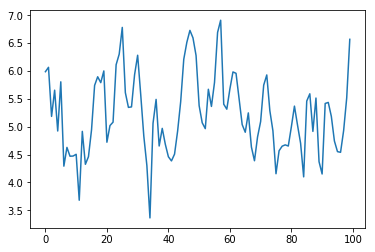

In [80]:
plt.plot(topEval[0])

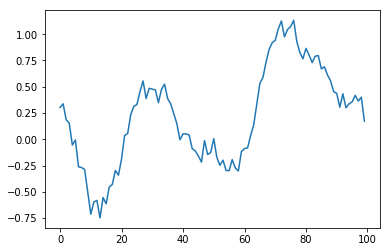

In [90]:
plt.plot(trace[2])

In [111]:
plt.figure(figsize=(200,200))
for i in np.arange(np.shape(np.array(results['W']))[2]):
    plt.subplot(10,10,i+1)
    plt.imshow(np.array(results['W'])[-1,0,i])
    #plt.colorbar()

In [5]:
def ising2dCouplings(BM,size=20,beta1=0.39,beta2=0.39,PBC=False):
    
    BM.layer.couplings =  beta1*(np.eye(N=size**2,k=1) + np.eye(N=size**2,k=-1)) + beta2*(np.eye(N=size**2,k=size) + np.eye(N=size**2,k=-size))
    
    N = size
    
    if PBC is True:
        # Add the couplings of the first row to that of the last row and vice versa:
        for i in np.arange(0,N):
            BM.layer.couplings[i,(size**2)-N+i] = beta2
            BM.layer.couplings[(size**2)-N+i,i] = beta2
        # Remove the couplings of the left most coloumn to that of the last coloumn in its previous row:
        for i in np.arange(0,N*N,N):
            BM.layer.couplings[i,i-1] = 0
            BM.layer.couplings[i-1,i] = 0
        # Add the couplings of the left most column to the right most coloumn:
            BM.layer.couplings[i,i+N-1] = beta1
            BM.layer.couplings[i+N-1,i] = beta1
    
    return BM.layer.couplings